In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report

In [2]:
print(os.getcwd())

C:\Users\Mattijs\Documents\Mattijs\GlobeDX\deep-orderbook


In [3]:
os.chdir('..')
os.chdir('Data')
print(os.getcwd())

C:\Users\Mattijs\Documents\Mattijs\GlobeDX\Data


In [34]:
def concat_data(base_path, features):
    """Concatenate all the files in basepath keeping only the
    columns specified by features.
    """
    l2_snapshot = pd.DataFrame()
    for i, x in enumerate(tqdm(os.listdir(base_path))): 
        path = base_path + x
        df_hour = pd.read_parquet(path, columns=features)
        l2_snapshot = pd.concat([l2_snapshot, df_hour.dropna()])
        
    return l2_snapshot

def extend_matrix(a, n):
    """Extend a one row matrix to n rows by duplicating rows"""
    a = np.repeat(a, repeats=n, axis=0)
    return a

def normalise_data_per_day(df):
    df_mean = df.resample('D').mean()
    df_var = df.resample('D').var()
    
    timestamps_per_day = np.unique(df.index.date, return_counts=True)[1]
    mean_array = extend_matrix(df_mean.to_numpy(), timestamps_per_day)
    var_array = extend_matrix(df_var.to_numpy(), timestamps_per_day)
    
    df = (df - mean_array) / var_array

    return df

def generate_X_y(df_snapshot, best_ask='a1', best_bid='b1', k=20, alpha=10e-5):
    """Return X, y from the snapshot dataframe and the best ask/bid columns."""
    df = pd.DataFrame()
    df['mid_price'] = (df_snapshot[best_ask].to_numpy()+df_snapshot[best_bid].to_numpy())/2

    # Create columns delayed by -k to k-1
    for i in range(-k, k):
        df[i] = df['mid_price'].shift(periods=i)

    # Drop first k-1 rows and last k rows
    df.drop(range(0,19), axis=0, inplace=True)
    df.drop(range(len(df_snapshot)-20,len(df_snapshot)), axis=0, inplace=True)
    
    # Compute mean of previous k and next k
    df['m_b'] = df[range(0,20)].mean(axis=1)
    df['m_a'] = df[range(-20,0)].mean(axis=1)
    
    # Compute label of increasing or decreasing
    y_increase = np.where(df['m_b'] > df['m_a'] * (1+alpha), 1, 0)
    y_decrease = np.where(df['m_b'] < df['m_a'] * (1-alpha), -1, 0)
    y = y_increase + y_decrease
    
    X = df_snapshot.to_numpy()[20:-20]
        
    return X, y

In [5]:
features = ['b1','b2','b3','b4','b5','b6','b7','b8', 'b9', 'b10', 'a1','a2','a3','a4','a5','a6','a7','a8', 'a9', 'a10', 'bq1','bq2','bq3','bq4','bq5','bq6','bq7','bq8', 'bq9', 'bq10', 'aq1','aq2','aq3','aq4','aq5','aq6','aq7','aq8', 'aq9', 'aq10']
base_path = 'coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/'

l2_snapshot = concat_data(base_path, features)

  0%|                                                                          | 0/216 [00:00<?, ?it/s]c:\users\mattijs\anaconda3\envs\globedx\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
c:\users\mattijs\anaconda3\envs\globedx\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
c:\users\mattijs\anaconda3\envs\globedx\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
100%|████████████████████████████████████████████████████████████████| 216/216 [06:42<00:00,  1.86s/it]


In [ ]:
l2_norm = normalise_data_per_day(l2_snapshot)

In [27]:
X, y = generate_features_labels(l2_norm)

In [33]:
sum(np.unique(y, return_counts=True)[1])

4839108

In [ ]:
X, y = generate_features_labels(l2_norm, ask='a1', bid = 'b1', alpha=5)

In [42]:
def compute_l2(counts):
    """Return l2"""
    sum_ = sum(counts)
    p = (1/3-(counts[0]/sum_))**2 + (1/3-(counts[1]/sum_))**2 + (1/3-(counts[2]/sum_))**2
    return (p/3)**2
    
# GridSearch
min_ = float('inf')
alpha_min = 0
for i in tqdm(np.logspace(-5,-20,20, endpoint = True)):
    X,y = generate_X_y(l2_norm, best_ask='a1', best_bid = 'b1', alpha=i)
    temp = np.unique(y, return_counts=True)[1]
    l2 = compute_l2(temp)
    if l2 < min_:
        min_ = l2
        alpha_min = i
    print(min_, alpha_min)

  5%|███▎                                                               | 1/20 [00:40<12:46, 40.34s/it]

0.0007239953679217784 1e-05


 10%|██████▋                                                            | 2/20 [01:16<11:43, 39.08s/it]

0.0007069476037468268 1.6237767391887209e-06


 15%|██████████                                                         | 3/20 [01:55<11:02, 38.95s/it]

0.0007055361466360202 2.6366508987303554e-07


 20%|█████████████▍                                                     | 4/20 [02:33<10:18, 38.68s/it]

0.0007052009743089568 4.281332398719396e-08


 25%|████████████████▊                                                  | 5/20 [03:11<09:37, 38.47s/it]

0.0007049766501416778 6.951927961775591e-09


 30%|████████████████████                                               | 6/20 [03:46<08:43, 37.40s/it]

0.0007049062733685257 1.1288378916846883e-09


 35%|███████████████████████▍                                           | 7/20 [04:23<08:04, 37.29s/it]

0.0007049062733685257 1.1288378916846883e-09


 40%|██████████████████████████▊                                        | 8/20 [05:00<07:26, 37.20s/it]

0.0007049062733685257 1.1288378916846883e-09


 45%|██████████████████████████████▏                                    | 9/20 [05:36<06:46, 36.97s/it]

0.0007049062733685257 1.1288378916846883e-09


 50%|█████████████████████████████████                                 | 10/20 [06:13<06:10, 37.04s/it]

0.0007049062733685257 1.1288378916846883e-09


 55%|████████████████████████████████████▎                             | 11/20 [06:51<05:34, 37.19s/it]

0.0007049037857156877 1.2742749857031322e-13


 60%|███████████████████████████████████████▌                          | 12/20 [07:28<04:57, 37.24s/it]

0.0007048758622108824 2.06913808111479e-14


 65%|██████████████████████████████████████████▉                       | 13/20 [08:06<04:22, 37.57s/it]

0.0007048205774311803 3.359818286283788e-15


 70%|██████████████████████████████████████████████▏                   | 14/20 [08:42<03:41, 36.96s/it]

0.0007047425908861713 5.455594781168515e-16


 75%|█████████████████████████████████████████████████▌                | 15/20 [09:22<03:09, 37.92s/it]

0.00016366202324770426 8.858667904100796e-17


 80%|████████████████████████████████████████████████████▊             | 16/20 [10:03<02:35, 38.77s/it]

0.00016366202324770426 8.858667904100796e-17


 85%|████████████████████████████████████████████████████████          | 17/20 [10:44<01:58, 39.55s/it]

0.00016366202324770426 8.858667904100796e-17


 90%|███████████████████████████████████████████████████████████▍      | 18/20 [11:23<01:18, 39.21s/it]

0.00016366202324770426 8.858667904100796e-17


 95%|██████████████████████████████████████████████████████████████▋   | 19/20 [11:59<00:38, 38.30s/it]

0.00016366202324770426 8.858667904100796e-17


100%|██████████████████████████████████████████████████████████████████| 20/20 [12:43<00:00, 38.17s/it]

0.00016366202324770426 8.858667904100796e-17


In [43]:
print(alpha_min, min_)

8.858667904100796e-17 0.00016366202324770426


In [45]:
X,y = generate_X_y(l2_norm, best_ask='a1', best_bid = 'b1', alpha=alpha_min)

In [46]:
l2_norm['mid_price'] = (l2_norm['a1']+l2_norm['b1'])/2

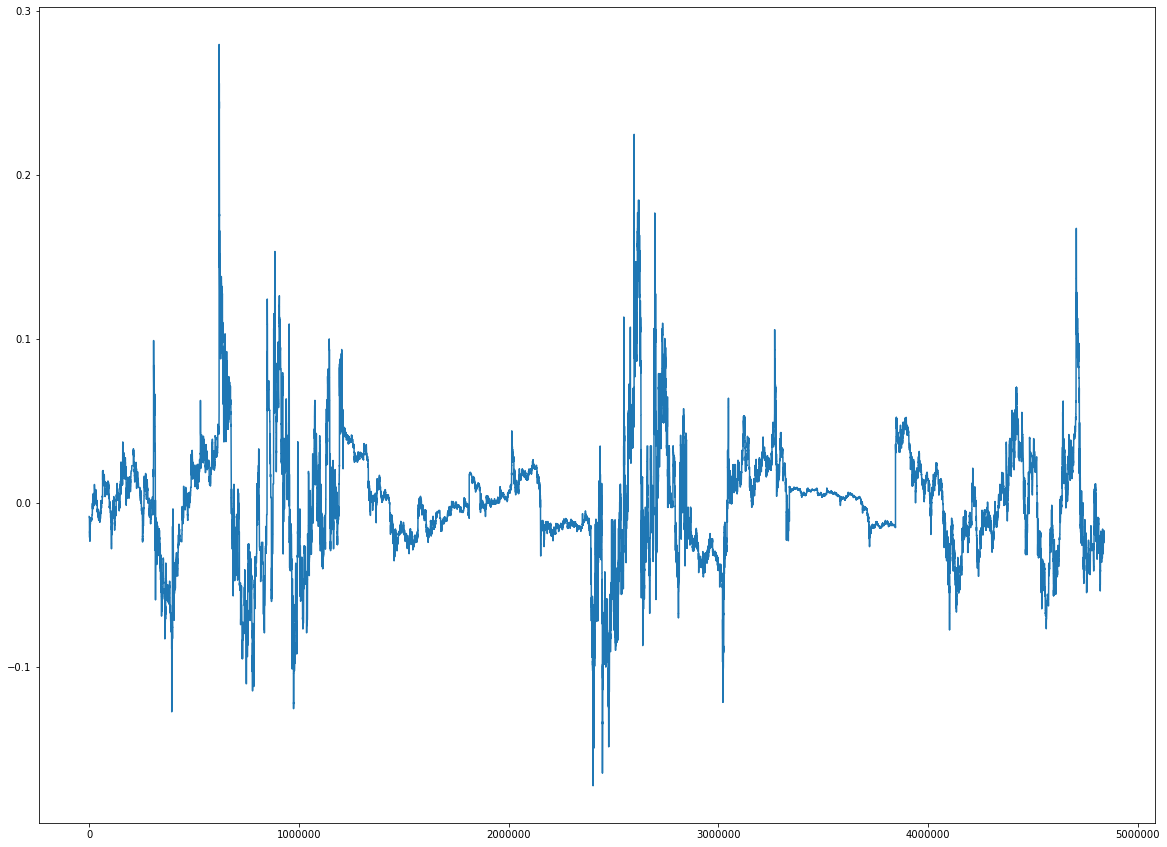

In [49]:
plt.figure(figsize = (20,15))
plt.plot(np.arange(1,l2_norm.shape[0]+1), l2_norm['mid_price'])
plt.show()

<class 'numpy.int32'>


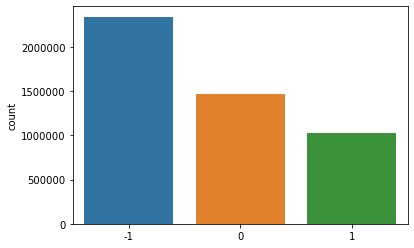

In [51]:
sns.countplot(x = y)

In [14]:
T = 100
D = 40
N = len(X) - T

In [15]:
trainPart = 3176026

In [16]:
X_train = np.zeros((trainPart, T, D), dtype = 'float32')
y_train = np.zeros(trainPart, dtype='float32')

#Preparing the time series data using timestep of 100 and no of features = 200
for t in range(trainPart):
    X_train[t, :, :] = X[t:t+T]
    y_train[t] = y[t+T] 


In [17]:
print('X_train - Before: {} GB'.format(X_train.nbytes/1024**3), X_train.dtype)

X_train - Before: 47.326475381851196 GB float32


In [18]:
print('y_train - Before: {} GB'.format(y_train.nbytes/1024**3), y_train.dtype)

y_train - Before: 0.011831618845462799 GB float32


In [19]:
X_test = np.zeros((N - trainPart, T, D), dtype = 'float32')
y_test = np.zeros(N - trainPart, dtype='float32')

#Preparing the time series data using timestep of 100 and no of features = 40
for k in range(N - trainPart):
    t = k + trainPart
    X_test[k, :, :] = X[t:t+T]
    y_test[k] = y[t+T]

print('X_test - Before: {} GB'.format(X_test.nbytes/1024**3), X_test.dtype)
print('y_test - Before: {} GB'.format(y_test.nbytes/1024**3), y_test.dtype)

X_test - Before: 16.33913815021515 GB float32
y_test - Before: 0.004084784537553787 GB float32


In [20]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [21]:
!pip install tensorflow-addons

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [22]:
import tensorflow_addons as tfa

In [23]:
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, Dense, LeakyReLU, Bidirectional, LSTM, Add, Activation, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [24]:
from tensorflow import keras
from functools import partial

In [25]:
## Resnet of Conv1D
DefaultConv1D = partial(keras.layers.Conv1D, kernel_size=4, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv1D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv1D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv1D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [26]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    inputs = keras.layers.Input(shape = (100,40))
    x = keras.layers.Conv1D(filters=16, kernel_size=4 ,activation='relu', padding='SAME')(inputs)
    x = keras.layers.MaxPooling1D(2)(x)
    
    prev_filters = 16
    for filters in [16]*3+[32]*2:
        if prev_filters != filters:
            stride = 2
        else:
            stride = 1
        x = ResidualUnit(filters, stride)(x)
        prev_filters = filters

    x = keras.layers.GlobalAveragePooling1D()(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)

    res_net_model = keras.models.Model(inputs, outputs)
    res_net_model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

In [27]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     i = Input(shape=X_train[0].shape)
    
#     x = Conv2D(16, (4,D),kernel_initializer="he_normal")(i)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = tf.keras.layers.Reshape(target_shape=(T-3,16))(x)
    
#     x = Conv1D(16, 4, kernel_initializer="he_normal")(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = MaxPooling1D(2)(x)
    
#     x = Conv1D(32, 3, activation=LeakyReLU(alpha=0.01), kernel_initializer="he_normal")(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = MaxPooling1D(2)(x)
    
#     x = Bidirectional(LSTM(64, return_sequences = False))(x)
    
#     x = Dense(32 ,kernel_initializer="he_normal")(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = Dense(32, kernel_initializer="he_normal")(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = Dense(3, activation='softmax', kernel_initializer="he_normal")(x)

#     model = Model(i,x)
#     model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
    

In [28]:
EPOCHS = 2
r = res_net_model.fit(
    X_train,y_train,
    epochs=EPOCHS,
    batch_size=128
)

Train on 3176026 samples
Epoch 1/2
INFO:tensorflow:batch_all_reduce: 37 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 37 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
3176026/3176026 [==============================] - 761s 240us/sample - loss: 0.5298 - accuracy: 0.7703
Epoch 2/2
3176026/3176026 [==============================] - 672s 212us/sample - loss: 0.4726 - accuracy: 0.8007


In [29]:
res_net_model.evaluate(X_test, y_test)

1096501/1096501 [==============================] - 263s 240us/sample - loss: 0.5219 - accuracy: 0.7813


[0.5219288663517122, 0.78128153]

In [30]:
y_pred = res_net_model.predict(X_test)

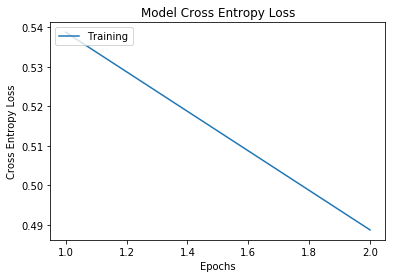

In [24]:
sns.lineplot(x=range(1,EPOCHS+1),y=r.history['loss'])
#sns.lineplot(x=range(1,EPOCHS+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left')

In [31]:
y_pred = y_pred.argmax(axis=1)

In [26]:
with strategy.scope():
    y_pred = model.predict(X_test).argmax(axis=1)

InternalError: 2 root error(s) found.
  (0) Internal:  No algorithm worked!
	 [[node replica_3/model/bidirectional/forward_cu_dnnlstm/CudnnRNNV2 (defined at /lib/python3.5/threading.py:914) ]]
  (1) Internal:  No algorithm worked!
	 [[node replica_3/model/bidirectional/forward_cu_dnnlstm/CudnnRNNV2 (defined at /lib/python3.5/threading.py:914) ]]
	 [[GroupCrossDeviceControlEdges_0/Identity_2/_73]]
0 successful operations.
2 derived errors ignored. [Op:__inference_distributed_function_962908]

Function call stack:
distributed_function -> distributed_function


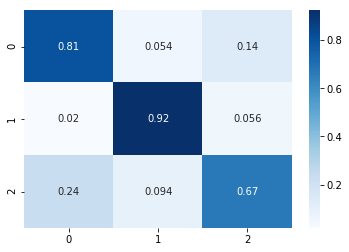

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax=sns.heatmap(cm, annot=True, xticklabels=[0,1,2], yticklabels=[0,1,2], cmap='Blues')
ax.set_ylim(3.0, 0)
plt.show()

In [33]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

        0.0       0.79      0.81      0.80    469694
        1.0       0.77      0.92      0.84    227557
        2.0       0.77      0.67      0.72    399250

avg / total       0.78      0.78      0.78   1096501

